# Matrix-based scaling experiment
> More scaling, this time with the matrix-based generator and solver

Updated Oct 27, 2023

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

In [3]:
plt.rc("font", size=20)

In [4]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [5]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

# This takes about 5 minutes for 100 samples
abundances, log_ptrs, otus = make_tables(n_genomes=10, n_samples=20, db=rnadb, sparsity=0, multiplier=1)

In [6]:
solver = TorchSolver(otus=otus, db=rnadb)

Using OTU index for md5s


In [7]:
def score(solver, true_abundances, true_log_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.R_hat.exp().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp(true_log_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances

# Effect of number of genomes

In [8]:
# results = pd.DataFrame()
results = pd.DataFrame(
    columns=[
        "n_genomes",
        "genome",
        "sample",
        "true_ptr",
        "inferred_ptr",
        "inferred_abundance",
        "abundance",
        "ptr_score",
        "abundance_score",
        "n_reads",
    ]
)

for n_genomes in range(1, 20):
    print(n_genomes)
    abundances, log_ptrs, otus = make_tables(
        n_genomes=n_genomes,
        n_samples=20 - n_genomes,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=1,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    solver.train(lr=0.1, clip=True, model_bias=False)
    R_scores, A_scores, R_inf, A_inf = score(
        solver=solver,
        true_log_ptrs=log_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                # results = results.append(
                results.loc[len(results)] = {
                    "n_genomes": n_genomes,
                    "genome": genome_id,
                    "sample": sample_id,
                    "true_ptr": np.exp(log_ptrs.loc[genome_id, sample_id]),
                    "inferred_ptr": R_inf.loc[genome_id, sample_id],
                    "inferred_abundance": A_inf.loc[genome_id, sample_id],
                    "abundance": abundances.loc[genome_id, sample_id],
                    "ptr_score": R_scores.loc[genome_id, sample_id],
                    "abundance_score": A_scores.loc[genome_id, sample_id],
                    "n_reads": otus.loc[rnadb[genome_id]["md5"].unique(), sample_id].sum(),
                }
                # },
                # ignore_index=True,
                # )
            except KeyError as e:
                print(f"=====KEY ERROR: {e}")

results

1
Using OTU index for md5s
Initial:	 122.4267807006836


/home/phil/mambaforge/envs/aptr/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0:	 -890.507080078125
Epoch 1:	 -1010.7561645507812
Epoch 2:	 -1081.6983642578125
Epoch 3:	 -1132.1585693359375
Epoch 4:	 -1170.7813720703125
Epoch 5:	 -1201.1976318359375
Epoch 6:	 -1225.2840576171875
Epoch 7:	 -1244.2122802734375
Epoch 8:	 -1258.813720703125
Epoch 9:	 -1269.7802734375
Epoch 10:	 -1277.755126953125
Epoch 11:	 -1283.3460693359375
Epoch 12:	 -1287.079833984375
Epoch 13:	 -1289.411376953125
Epoch 14:	 -1290.7327880859375
Epoch 15:	 -1291.3826904296875
Epoch 16:	 -1291.642578125
Epoch 17:	 -1291.7386474609375
Epoch 18:	 -1291.8236083984375
Epoch 19:	 -1291.911865234375
Epoch 20:	 -1291.99169921875
Epoch 21:	 -1292.0543212890625
Epoch 22:	 -1292.097412109375
Epoch 23:	 -1292.1246337890625
Epoch 24:	 -1292.1396484375
Epoch 25:	 -1292.146728515625
Epoch 26:	 -1292.148681640625
Epoch 27:	 -1292.1495361328125
Epoch 28:	 -1292.1492919921875
Epoch 29:	 -1292.1497802734375
Epoch 30:	 -1292.14990234375
Epoch 31:	 -1292.1488037109375
Epoch 32:	 -1292.1497802734375
Epoch 33:	 

,n_genomes,genome,sample,true_ptr,inferred_ptr,inferred_abundance,abundance,ptr_score,abundance_score,n_reads
0,1,1771.11,0,1.805244,2.000000,352.208435,1.073637,-0.194756,-351.134798,440.0
1,1,1771.11,1,1.863667,1.845231,1306.895508,4.291477,0.018436,-1302.604031,1723.0
2,1,1771.11,2,1.227015,1.044477,341.594025,1.287651,0.182538,-340.306373,660.0
3,1,1771.11,3,1.151281,1.990646,237.120621,0.547723,-0.839365,-236.572898,297.0
4,1,1771.11,4,1.287208,2.000000,200.919067,0.433074,-0.712792,-200.485993,251.0
...,...,...,...,...,...,...,...,...,...,...
1325,19,570277.3,0,1.120574,1.107445,1615.976929,5.361077,0.013128,-1610.615851,11013.0
1326,19,743973.3,0,1.097295,1.000000,380.500061,1.398339,0.097295,-379.101722,761.0
1327,19,1538.8,0,1.463511,1.216067,461.444427,1.603840,0.247444,-459.840588,3967.0
1328,19,469371.5,0,1.689259,1.635526,254.495850,0.795954,0.053733,-253.699896,848.0


In [9]:
results.to_csv("../../data/figures/scaling_experiment_matrix.tsv", index=False, sep="\t")

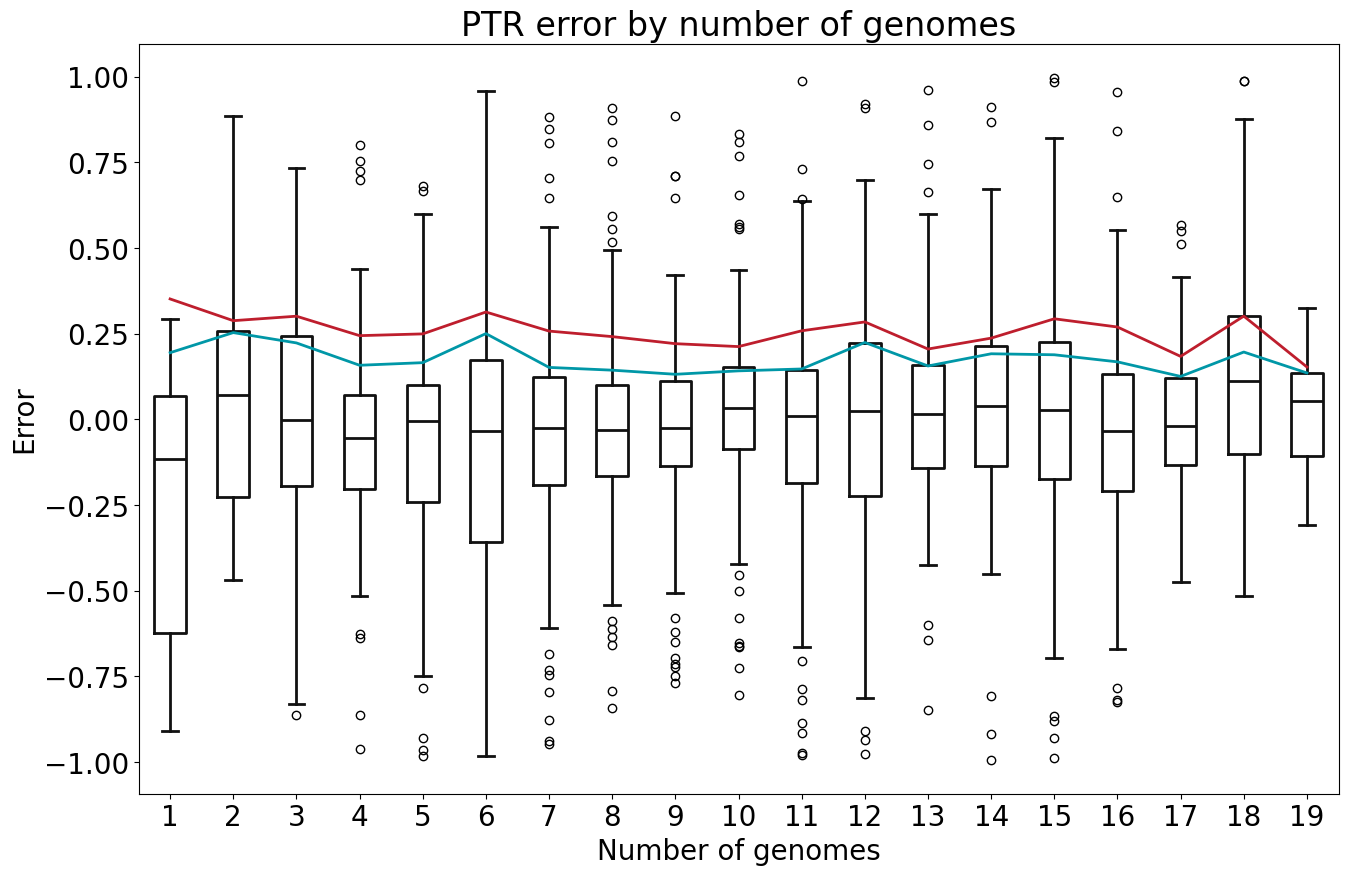

In [10]:
results.boxplot(
    by="n_genomes",
    column="ptr_score",
    figsize=(15, 10),
    grid=False,
)

# Make boxplots thicker and #111111
for i, artist in enumerate(plt.gca().get_children()):
    if isinstance(artist, plt.Line2D):
        artist.set_color("#111111")
        artist.set_linewidth(2)

# Draw error on same figure with different y axis
plt.plot(
    np.arange(1, 20),
    results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").mean()["ptr_score"],
    c="#BE1E2D",
    lw=2,
)
plt.plot(
    np.arange(1, 20),
    results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").median()["ptr_score"],
    c="#0097A7",
    lw=2,
)
plt.ylabel("Error")
plt.xlabel("Number of genomes")
plt.title("PTR error by number of genomes")
plt.suptitle("")

# Convert xlabel to integers
plt.xticks(np.arange(1, 20), np.arange(1, 20))

plt.show()

Text(0.5, 1.0, 'PTR agreement in genome size experiment')

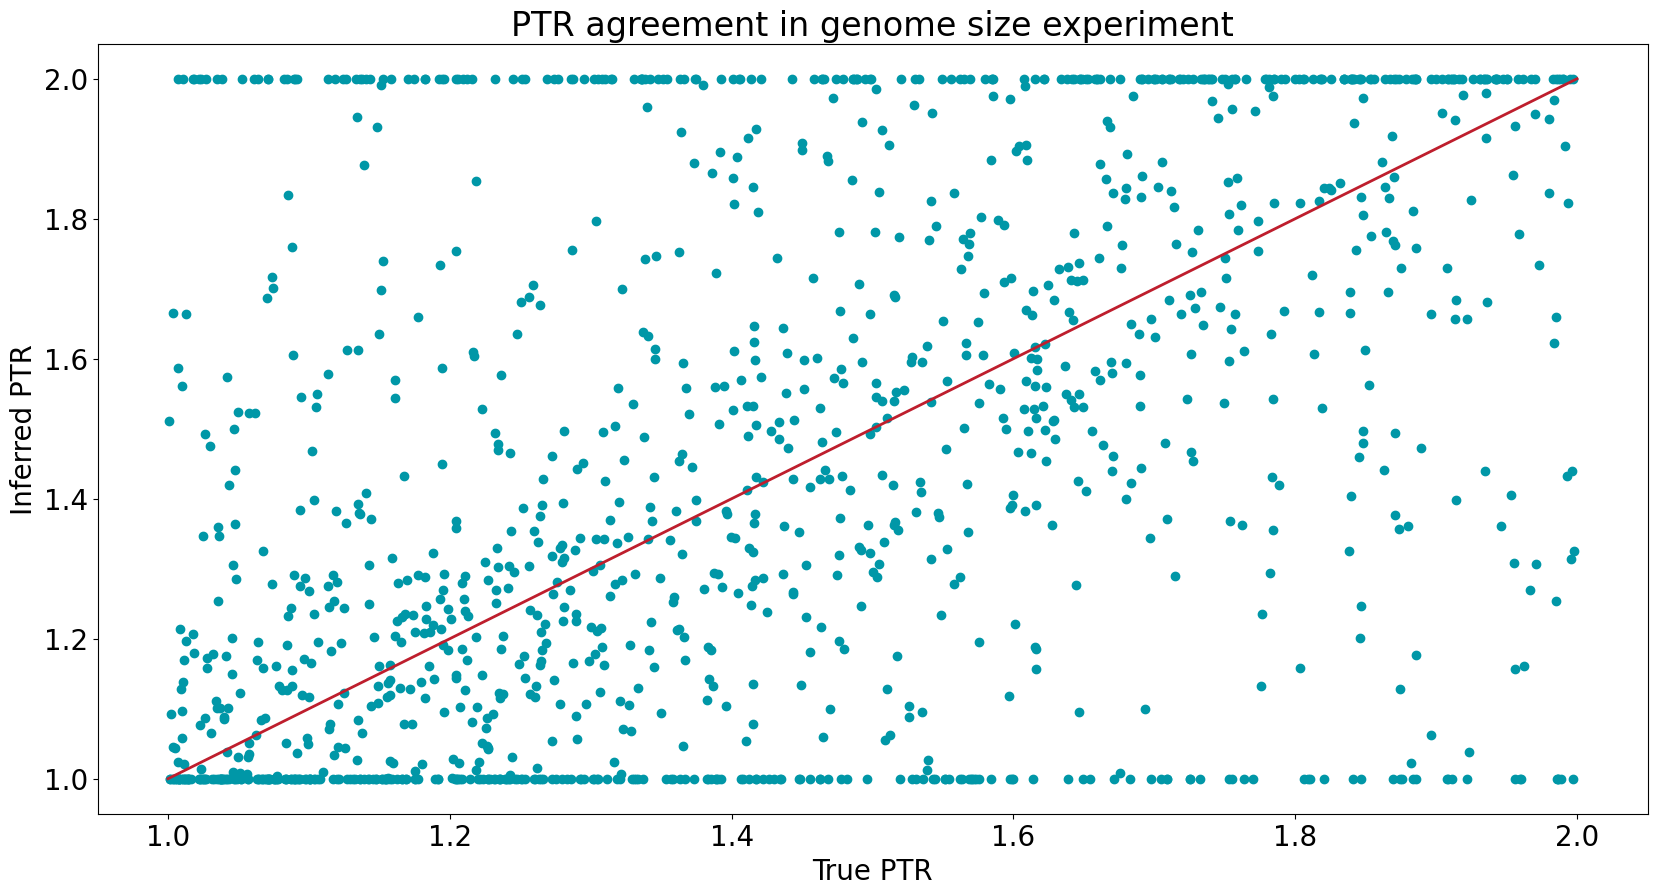

In [11]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["true_ptr"], results["inferred_ptr"], c="#0097A7")
plt.plot([1, 2], [1, 2], c="#BE1E2D", lw=2)
plt.xlabel("True PTR")
plt.ylabel("Inferred PTR")
plt.title("PTR agreement in genome size experiment")

# Effect of scaling factor

In [17]:
# results_scaling = pd.DataFrame()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

results_scaling = pd.DataFrame(
    columns=[
        "scaling",
        "genome",
        "sample",
        "true_ptr",
        "inferred_ptr",
        "inferred_abundance",
        "abundance",
        "ptr_score",
        "abundance_score",
        "n_reads",
    ]
)

for scaling_factor in range(-5, 5):
    print(scaling_factor)
    abundances, log_ptrs, otus = make_tables(
        n_genomes=5,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=10**scaling_factor,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    try:
        solver.train(lr=0.1, clip=True)
    except Exception as e:
        print(e)
        continue
    R_scores, A_scores, R_inf, A_inf = score(
        solver=solver,
        true_log_ptrs=log_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                # results_scaling = results_scaling.append(
                results_scaling.loc[len(results_scaling)] = {
                    "scaling": scaling_factor,
                    "genome": genome_id,
                    "sample": sample_id,
                    "true_ptr": np.exp(log_ptrs.loc[genome_id, sample_id]),
                    "inferred_ptr": R_inf.loc[genome_id, sample_id],
                    "inferred_abundance": A_inf.loc[genome_id, sample_id],
                    "abundance": abundances.loc[genome_id, sample_id],
                    "ptr_score": R_scores.loc[genome_id, sample_id],
                    "abundance_score": A_scores.loc[genome_id, sample_id],
                    "n_reads": otus.loc[rnadb[genome_id]["md5"].unique(), sample_id].sum(),
                }
                # },
                # ignore_index=True,
                # )
            except Exception as e:
                print(e)

results_scaling

-5
Using OTU index for md5s
Initial:	 1.2347841262817383
Epoch 0:	 0.05263157933950424
Epoch 1:	 0.05263157933950424
Epoch 2:	 0.05263157933950424
Epoch 3:	 0.05263157933950424
Epoch 4:	 0.05263157933950424
Epoch 5:	 0.05263157933950424
Epoch 6:	 0.05263157933950424
-4
Using OTU index for md5s
Initial:	 0.9798661470413208
Epoch 0:	 0.12601016461849213
Epoch 1:	 0.12601016461849213
Epoch 2:	 0.12601016461849213
Epoch 3:	 0.12601016461849213
Epoch 4:	 0.12601016461849213
Epoch 5:	 0.12601017951965332
Epoch 6:	 0.12601029872894287
-3
Using OTU index for md5s
Initial:	 0.988311767578125
Epoch 0:	 0.43749913573265076
Epoch 1:	 0.43749913573265076
Epoch 2:	 0.43749916553497314
Epoch 3:	 0.43750089406967163
Epoch 4:	 0.43749943375587463
Epoch 5:	 0.43749919533729553
Epoch 6:	 0.43750184774398804
-2
Using OTU index for md5s
Initial:	 0.7593817710876465
Epoch 0:	 -2.2536866664886475
Epoch 1:	 -2.258885622024536
Epoch 2:	 -2.2608466148376465
Epoch 3:	 -2.2618908882141113
Epoch 4:	 -2.26253223419

,scaling,genome,sample,true_ptr,inferred_ptr,inferred_abundance,abundance,ptr_score,abundance_score,n_reads
0,-5,334390.5,1,1.622436,2.000000,0.000000,0.185047,-0.377564,0.185047,0.0
1,-5,334390.5,13,1.908883,2.000000,0.000000,0.988594,-0.091117,0.988594,0.0
2,-5,653733.4,1,1.937305,2.000000,0.000000,0.020275,-0.062695,0.020275,0.0
3,-5,653733.4,13,1.466022,1.985019,0.843189,0.883923,-0.518997,0.040734,1.0
4,-5,340047.17,1,1.546920,2.000000,0.000000,0.614587,-0.453080,0.614587,0.0
...,...,...,...,...,...,...,...,...,...,...
850,4,477641.3,15,1.400361,1.409345,433.302765,0.361667,-0.008983,-432.941098,2807924.0
851,4,477641.3,16,1.242265,1.249420,956.919495,0.797612,-0.007154,-956.121883,6521466.0
852,4,477641.3,17,1.744908,1.748039,58.971973,0.049045,-0.003131,-58.922929,348996.0
853,4,477641.3,18,1.768156,1.757487,219.019760,0.183010,0.010669,-218.836750,1291400.0


In [18]:
results_scaling.to_csv("../../data/figures/scaling_experiment_matrix2.tsv", index=False, sep="\t")

/tmp/ipykernel_2802654/1245914067.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("viridis", len(scaling_factors))
/tmp/ipykernel_2802654/1245914067.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


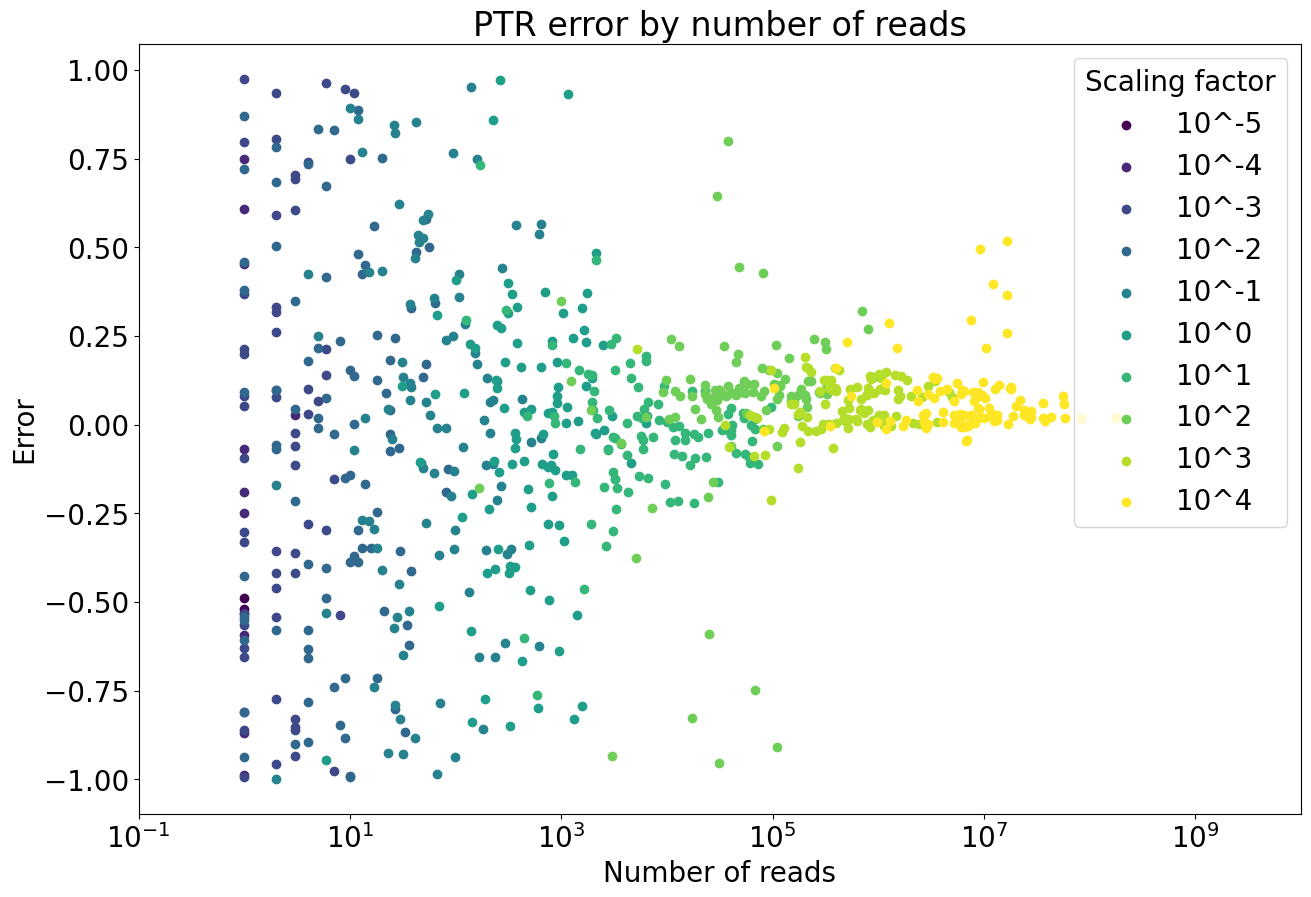

In [24]:
from matplotlib import cm

scaling_factors = results_scaling["scaling"].unique()

figure = plt.figure(figsize=(15, 10))
colors = cm.get_cmap("viridis", len(scaling_factors))

for i, scaling_factor in enumerate(scaling_factors):
    plt.scatter(
        results_scaling[results_scaling["scaling"] == scaling_factor]["n_reads"],
        results_scaling[results_scaling["scaling"] == scaling_factor]["ptr_score"],
        label=f"10^{scaling_factor}",
        c=colors(i),
    )
# plt.scatter(results_scaling["n_reads"], results_scaling["ptr_score"], c="#0097A7")
plt.xscale("log")
plt.xlim([0.1, 1e10])
plt.xlabel("Number of reads")
plt.ylabel("Error")
plt.title("PTR error by number of reads")
plt.legend(title="Scaling factor")
plt.show()